In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

!pip install livelossplot
from livelossplot import PlotLosses

# If on drive retrieve the images
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/Fiber Finder/generative/images.zip'
    local_path = '/content/'
    !cp -r "$data_path" "$local_path"
    !unzip "/content/images.zip" -d "/content" > /dev/null 2>&1
    print('Data recieved and unzipped!')

except Exception as e:
    print('No Drive or Error:', e)

data_path = './images'

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Mounted at /content/drive
Data recieved and unzipped!
Cuda installed! Running on GPU!


In [2]:
class FiberDataset(Dataset):
    """Creates a dataset from an image file."""
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.files = os.listdir(image_dir)
        self.image_paths = []

        self.labels = {}
        self.false = []

        self._parse_files()

    def _parse_files(self):
        for file_name in self.files:
            file_name = os.path.join(self.image_dir, file_name)
            if file_name.endswith(".png"):
                self.image_paths.append(file_name)
            elif file_name.endswith(".csv"):
                labels = pd.read_csv(file_name, header=None)[0]
                labels.index += 1
                labels.index += 2000
                labels = dict(labels)
                self.labels = labels
            else:
                self.false.append(file_name)
        pass

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        file_name = self.image_paths[idx]
        image_no = int(file_name.split("/")[-1].replace(".png", ""))
        image = Image.open(file_name).convert('L')

        label = self.labels[image_no]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([transforms.ToTensor()])

data_path_bio = data_path + "/bio/"
data_path_bio = data_path + "/diffusion_voxels/"

dataset = FiberDataset(data_path_bio, transform=transform)
exp_loader = DataLoader(dataset, batch_size=1, shuffle=False)


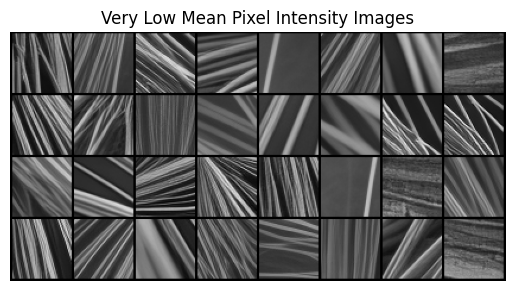

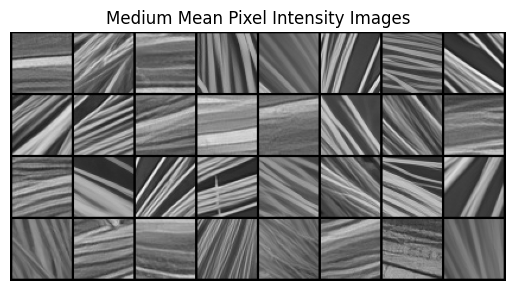

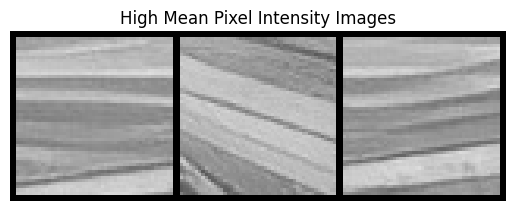

In [3]:
def show_images_grid(images, title=None, nrow=8):
    """Plots the images in a grid"""
    img_grid = make_grid(images, nrow=nrow).numpy()
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# DataLoader for the dataset
exp_loader = DataLoader(dataset, shuffle=True)

# Thresholds
low_threshold = 0.4
high_threshold = 0.65

# Lists to store samples
very_low_mean_samples = []
medium_mean_samples = []
high_mean_samples = []

for images, labels in exp_loader:
    for img in images:
        mean_intensity = img.mean()
        if mean_intensity <= low_threshold and len(very_low_mean_samples) < 32:
            very_low_mean_samples.append(img)
        elif low_threshold < mean_intensity <= high_threshold and len(medium_mean_samples) < 32:
            medium_mean_samples.append(img)
        elif mean_intensity > high_threshold and len(high_mean_samples) < 32:
            high_mean_samples.append(img)

    if len(very_low_mean_samples) >= 32 and len(medium_mean_samples) >= 32 and len(high_mean_samples) >= 32:
        break

show_images_grid(very_low_mean_samples, "Very Low Mean Pixel Intensity Images")
show_images_grid(medium_mean_samples, "Medium Mean Pixel Intensity Images")
show_images_grid(high_mean_samples, "High Mean Pixel Intensity Images")

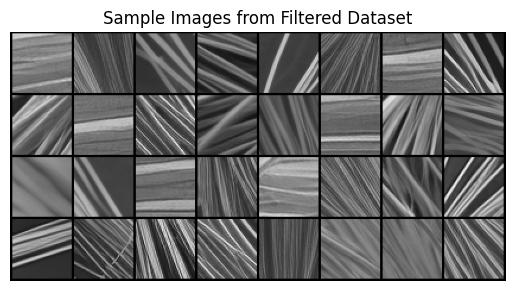

In [4]:
class FilteredDataset(Dataset):
    """Creates a filtered set from the standard dataset using tresholds."""
    def __init__(self, original_dataset, low_threshold=0., high_threshold=1, transform=None):
        self.transform = transform
        self.data = [(img, label) for img, label in original_dataset if low_threshold < img.mean() <= high_threshold]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([transforms.ToTensor()])

dataset = FiberDataset(data_path_bio, transform=transform)
filtered_dataset = FilteredDataset(dataset, low_threshold=.1, high_threshold=.65)
filtered_loader = DataLoader(filtered_dataset, batch_size=1, shuffle=False)
filtered_samples = []

for i, data in enumerate(filtered_dataset):
    image = data[0]
    filtered_samples.append(image)
    if i >= 31:
        break

show_images_grid(filtered_samples, "Sample Images from Filtered Dataset")


In [65]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()])

dataset = FiberDataset(data_path_bio, transform=transform)
filtered_dataset = FilteredDataset(dataset, low_threshold=.1, high_threshold=.65)
loader = DataLoader(filtered_dataset, batch_size=64, shuffle=False)

In [66]:
# U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.enc1 = self.encoder_block(input_size, hidden_dim, batch_norm=False)
        self.enc2 = self.encoder_block(hidden_dim, hidden_dim * 2)
        self.enc3 = self.encoder_block(hidden_dim * 2, hidden_dim * 4)
        self.enc4 = self.encoder_block(hidden_dim * 4, hidden_dim * 8)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Linear(hidden_dim * 8, hidden_dim * 16),
            nn.ReLU(True),
            nn.Dropout(0.5)
        )

        # Decoder
        self.dec1 = self.decoder_block(hidden_dim * 16, hidden_dim * 8)
        self.dec2 = self.decoder_block(hidden_dim * 8, hidden_dim * 4)
        self.dec3 = self.decoder_block(hidden_dim * 4, hidden_dim * 2)
        self.dec4 = self.decoder_block(hidden_dim * 2, hidden_dim, batch_norm=False)

        # Output
        self.out = nn.Sequential(
            nn.Linear(hidden_dim, 50*50),
            nn.Tanh()
        )

    def encoder_block(self, in_channels, out_channels, batch_norm=True):
        layers = [nn.Linear(in_channels, out_channels)]
        if batch_norm:
            layers.append(nn.BatchNorm1d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def decoder_block(self, in_channels, out_channels, batch_norm=True):
        layers = [nn.Linear(in_channels, out_channels)]
        if batch_norm:
            layers.append(nn.BatchNorm1d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Bottleneck
        b = self.bottleneck(e4)

        # Decoder with skip connections
        d1 = self.dec1(b)
        d2 = self.dec2(d1 + e4)  # Skip connection
        d3 = self.dec3(d2 + e3)  # Skip connection
        d4 = self.dec4(d3 + e2)  # Skip connection

        # Output
        out = self.out(d4 + e1)  # Skip connection
        return out

# Discriminator with Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(50*50, hidden_dim * 4)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.spectral_norm(nn.Linear(hidden_dim * 4, hidden_dim * 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.spectral_norm(nn.Linear(hidden_dim * 2, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.utils.spectral_norm(nn.Linear(hidden_dim, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)


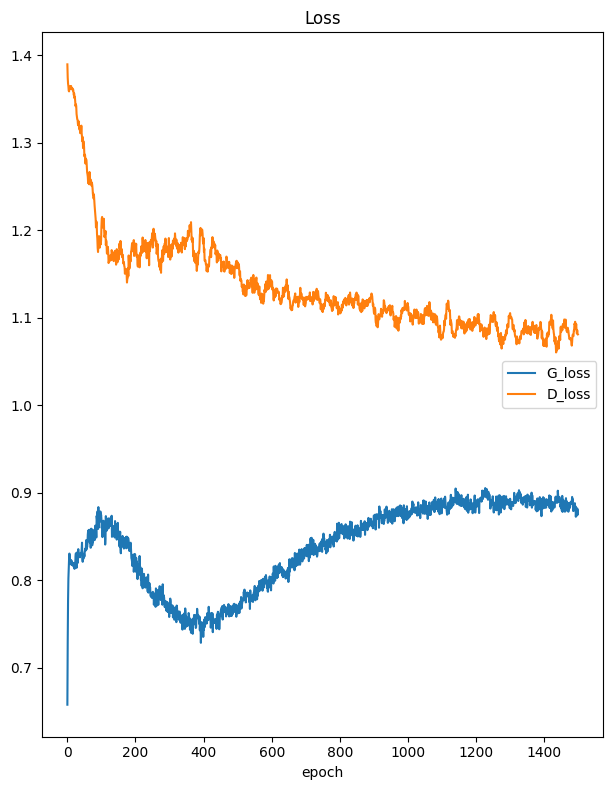

Loss
	G_loss           	 (min:    0.658, max:    0.905, cur:    0.880)
	D_loss           	 (min:    1.060, max:    1.390, cur:    1.081)


In [67]:
def train_gan(generator, discriminator, data_loader, epochs, save=False):
    # Optimizers
    lr = 1e-5

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

    # Loss function
    loss_function = nn.BCELoss()

    groups = {'Loss': ['G_loss', 'D_loss']}
    liveloss = PlotLosses(groups=groups)
    for epoch in range(epochs):
        logs = {}
        g_loss, d_loss = 0, 0

        for real_data, _ in data_loader:
            batch_size = real_data.size(0)
            real_data = real_data.view(batch_size, -1).to(device)

            # Train Discriminator with real data
            d_optimizer.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            real_loss = loss_function(discriminator(real_data), real_labels)
            real_loss.backward()

            # Train Discriminator with fake data
            noise = torch.randn(batch_size, input_size).to(device)
            fake_data = generator(noise)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_loss = loss_function(discriminator(fake_data.detach()), fake_labels)
            fake_loss.backward()
            d_optimizer.step()

            d_loss += real_loss.item() + fake_loss.item()

            # Train Generator
            g_optimizer.zero_grad()
            gen_loss = loss_function(discriminator(fake_data), real_labels)
            gen_loss.backward()
            g_optimizer.step()
            g_loss += gen_loss.item()

        # Average losses for current epoch
        logs['G_loss'] = g_loss / len(data_loader)
        logs['D_loss'] = d_loss / len(data_loader)

        # Update livelossplot
        liveloss.update(logs)
        liveloss.send()

        # Save model parameters every 'save_interval' epochs
        if (epoch+1) % 10 == 0 and save:
            g_path = f'generator_epoch_{epoch + 1}.pth'
            d_path = f'discriminator_epoch_{epoch + 1}.pth'
            torch.save(generator.state_dict(), os.path.join(model_path, g_path))
            # torch.save(discriminator.state_dict(), os.path.join(model_path, d_path))

    return generator, discriminator


# Example initialization
input_size = 100  # Example input size
hidden_dim = 128  # Example hidden dimension size

generator = Generator(input_size, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Training the GAN
epochs = 1500
model_path = './drive/MyDrive/Fiber Finder/generative/models/GAN'
model_path = './GAN'
gan = train_gan(generator, discriminator, loader, epochs, save=True)



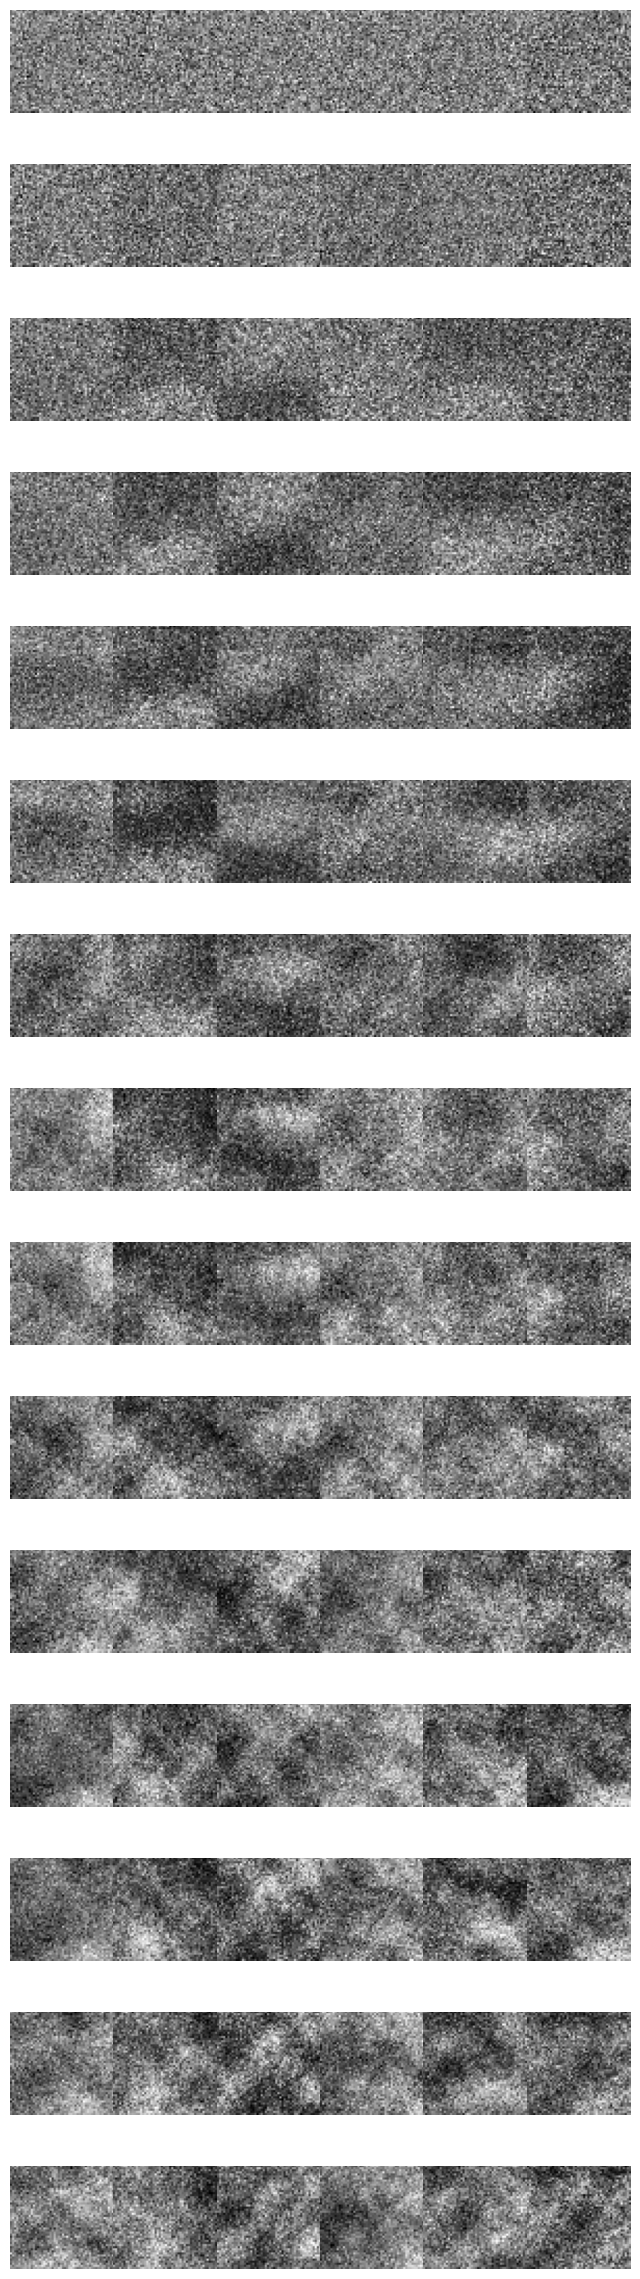

In [69]:
def load_generator_model(model, epoch, device):
    g_path = f'generator_epoch_{epoch}.pth'
    model.load_state_dict(torch.load(os.path.join(model_path, g_path)))
    model.to(device)
    model.eval()

# Assuming the generator architecture and input_size are defined
generator = Generator(input_size, hidden_dim).to(device)

epochs_to_load = range(10, epochs, 100)

fixed_noise = torch.randn(6, input_size).to(device)
num_rows = len(epochs_to_load)
num_cols = 6

_, axs = plt.subplots(num_rows, num_cols, figsize=(8, num_rows * 2.), gridspec_kw={'hspace': 0, 'wspace': 0})

for row, epoch in enumerate(epochs_to_load):
    load_generator_model(generator, epoch, device)

    with torch.no_grad():
        generated_images = generator(fixed_noise).view(-1, 50, 50).cpu()

    for col in range(num_cols):
        axs[row, col].imshow(generated_images[col], cmap='gray')
        axs[row, col].axis('off')
        if col == 0:
            axs[row, col].set_ylabel(f'Epoch {epoch}', size='large')

plt.show()

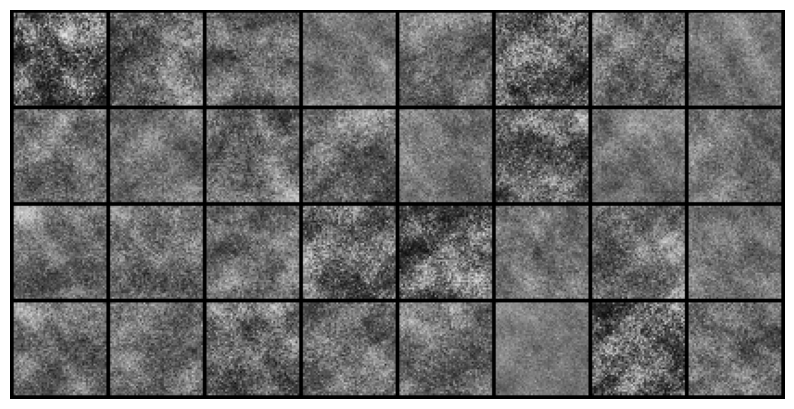

In [70]:
def plot_samples(model, num_samples=32, nrow=8, save=False, model_type='VAE'):
    save_dir=f'./{model_type}_fiber'
    # Generate random latent vectors
    z = torch.randn(num_samples, model.fc[0].in_features).to(device)

    # Decode the latent vectors
    model.eval()
    with torch.no_grad():
        imgs = model(z).view(-1, 1, 50, 50).to('cpu')
    # Create a grid of images and display
    img_grid = make_grid(imgs, nrow=nrow)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

    # Save the images if requested
    if save:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for i, img in enumerate(imgs):
            fname = f'{str(i+1).zfill(3)}.jpeg'
            img_np = img.squeeze().numpy()
            if img_np.max() <= 1:
                img_np = (img_np * 255).astype(np.uint8)
            img_pil = Image.fromarray(img_np)
            img_pil.save(os.path.join(save_dir, fname))

trained_generator = gan[0]

plot_samples(trained_generator, num_samples=32, nrow=8, save=False, model_type='GAN')